# -------------- Project "Advanced topics in financial modeling ------------------
# Prof : Nicolas Gaussel 
# Students : Outmane Mghanen && Tariq Ouahmane

In [22]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import plotly.express as px
from scipy.stats import skew, kurtosis
from datetime import timedelta
from sklearn.metrics import r2_score

In [24]:
# Function to calculate trading impact factor
def calculate_trading_impact_factor(l, sigma_s, T):
    return np.exp(-0.5 * T * (l**2 - l) * sigma_s**2)

# Function to calculate annualized statistics
def annualized_statistics(log_returns, trading_days_per_year=252, risk_free_rate=0.02):
    annualized_mean = log_returns.mean() * trading_days_per_year
    annualized_volatility = log_returns.std() * np.sqrt(trading_days_per_year)
    annualized_skewness = log_returns.apply(skew)
    annualized_kurtosis = log_returns.apply(kurtosis)

    sharpe_ratios = (annualized_mean - risk_free_rate) / annualized_volatility

    return pd.concat([annualized_mean, annualized_volatility, annualized_skewness, annualized_kurtosis, sharpe_ratios], axis=1,
                     keys=['Mean', 'Volatility', 'Skewness', 'Kurtosis', 'Sharpe Ratio'])

# 1/ Descriptive data analysis

[*********************100%***********************]  4 of 4 completed


/Users/outmanemghanen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


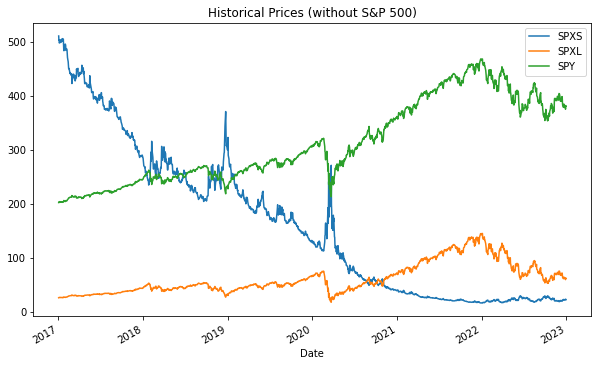

In [25]:
# Download data from Yahoo Finance from 2017 to 2022 included - S&P500 is ^GSPC
tickers = ['SPXS', 'SPXL', 'SPY', '^GSPC']
start_date = '2017-01-01'
end_date = '2022-12-31'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Statistics for each year and overall period
years = range(2017, 2023)

statistics = {}
for year in years:
    log_returns_year = log_returns.loc[f'{year}-01-01':f'{year}-12-31']
    statistics[year] = annualized_statistics(log_returns_year)

statistics['Overall'] = annualized_statistics(log_returns)

# Combination of statistics into a DataFrame by years
statistics_df = pd.concat(statistics, axis=1)

# Daily percentage changes
percentage_changes = data.pct_change().dropna()

# Daily percentage changes of S&P 500 with leveraged ETFs
percentage_changes['SPXS_vs_SP500'] = -3 * percentage_changes['^GSPC']
percentage_changes['SPXL_vs_SP500'] = 3 * percentage_changes['^GSPC']

comparison = pd.DataFrame()
comparison['SPXS_Error'] = percentage_changes['SPXS_vs_SP500'] - percentage_changes['SPXS']
comparison['SPXL_Error'] = percentage_changes['SPXL_vs_SP500'] - percentage_changes['SPXL']

# Historical prices without S&P 500
data_without_sp500 = data[['SPXS', 'SPXL', 'SPY']]
data_without_sp500.plot(title='Historical Prices (without S&P 500)', figsize=(10, 6))
plt.show()



Historically we can notice from the graph that SPY and SPXL are strongly correlated while SPXS is decorrelated from the other two. Overall, The behavior seem to be as they suggested, however, lets focus with detail to see if any precautions should be taken. Next we will analyze year by year statistics and also averall behavior over 2017-2022 period.

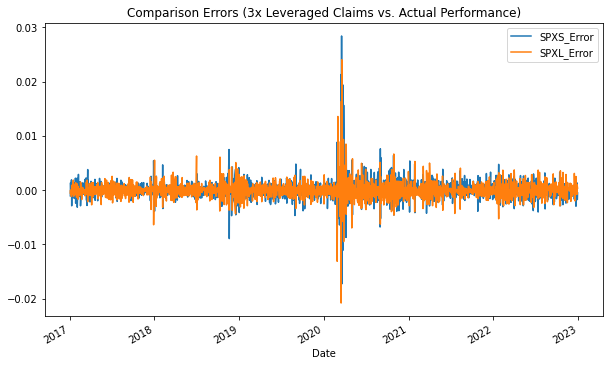

In [26]:
# Plot comparison errors
comparison.plot(title='Comparison Errors (3x Leveraged Claims vs. Actual Performance)', figsize=(10, 6))
plt.show()

in the graph above we plot the claims of direxion ( short and long 3x leverage exposure compared to S&P500) with the actual performance. We can see that the error is very small ( less than 1%) except in the year 2020 where it stays small but becomes three times larger compared to other years.This is mainly due to the sudden jump that happened in 2020.

In [27]:
correlation_matrices = {}
for year in years:
    log_returns_year = log_returns.loc[f'{year}-01-01':f'{year}-12-31']
    correlation_matrices[year] = log_returns_year.corr()

correlation_matrices['Overall'] = log_returns.corr()

# Correlation matrices year by year and overall
for key, correlation_matrix in correlation_matrices.items():
    print(f"\n{'*' * 20}\nCorrelation Matrix: {key}\n{'*' * 20}")
    print(correlation_matrix)


********************
Correlation Matrix: 2017
********************
           SPXL      SPXS       SPY     ^GSPC
SPXL   1.000000 -0.997207  0.998214  0.996468
SPXS  -0.997207  1.000000 -0.996960 -0.995797
SPY    0.998214 -0.996960  1.000000  0.996620
^GSPC  0.996468 -0.995797  0.996620  1.000000

********************
Correlation Matrix: 2018
********************
           SPXL      SPXS       SPY     ^GSPC
SPXL   1.000000 -0.996287  0.998680  0.998595
SPXS  -0.996287  1.000000 -0.997634 -0.997389
SPY    0.998680 -0.997634  1.000000  0.998865
^GSPC  0.998595 -0.997389  0.998865  1.000000

********************
Correlation Matrix: 2019
********************
           SPXL      SPXS       SPY     ^GSPC
SPXL   1.000000 -0.997743  0.998953  0.998525
SPXS  -0.997743  1.000000 -0.998141 -0.997904
SPY    0.998953 -0.998141  1.000000  0.998589
^GSPC  0.998525 -0.997904  0.998589  1.000000

********************
Correlation Matrix: 2020
********************
           SPXL      SPXS       SPY   

As predicted visually by the graph, SPY is strongly correlated with S&P 500 and SPXL while these three are strongly decorrelated from SPXS. This statement is true for each year and for the overall period

In [28]:
# Statistics year by year and overall
for key in statistics_df.columns.levels[0]:
    print(f"\n{'*' * 20}\nStatistics: {key}\n{'*' * 20}")
    print(statistics_df[key])


********************
Statistics: 2017
********************
           Mean  Volatility  Skewness  Kurtosis  Sharpe Ratio
SPXL   0.519857    0.195970 -0.506232  3.088759      2.550687
SPXS  -0.570226    0.197096  0.357569  2.745893     -2.994609
SPY    0.190323    0.067230 -0.446147  2.797688      2.533446
^GSPC  0.170378    0.066551 -0.481336  3.008064      2.259570

********************
Statistics: 2018
********************
           Mean  Volatility  Skewness  Kurtosis  Sharpe Ratio
SPXL  -0.290341    0.513115 -0.651108  2.891849     -0.604817
SPXS   0.033921    0.509073  0.129634  3.572174      0.027346
SPY   -0.046953    0.170807 -0.479167  3.178163     -0.391980
^GSPC -0.064659    0.170988 -0.500288  3.007233     -0.495119

********************
Statistics: 2019
********************
           Mean  Volatility  Skewness  Kurtosis  Sharpe Ratio
SPXL   0.707032    0.375112 -0.767700  3.401776      1.831538
SPXS  -0.830066    0.372688  0.416855  3.221650     -2.280906
SPY    0.27173

An overall observation is that volatility of SPXL and SPXS are always higher that SPY which make sense since these ETFs offers 3 times short and long leverage exposure. Also the market returns are generally skewed to negative values. In addition, in clear Bull markets like 2021 and 2017 the SPXL behave like direxion says and offers higher returns. Same in Bear market like 2018 and 2020 the SPXS offers a positive return.
However, this statement should be taken with a big bucket of salt. As we need to analyze also sharpe ratios and kurtosis. In fact, high kurtosis indicates more extreme outcomes, either positive or negative, while higher Sharpe ratios indicate better risk-adjusted performance.
As an example, in 2020 we are in the presence of a big jump in the market and even tough we are in an overall bull behavior SPY offer better risk adjusted returns (better sharpe ratio), furthermore, kurtosis is much lower for SPY in this year wich translate in less extreme outcomes, finally, returns of SPXL are less than SPY.
Second example is 2019, even tough we are in a clear bull market with no big jumps in prices. SPY still offers a better Sharpe ratio.
Finally, If a client wanted to invest long term in these ETFs it would be a disaster, In fact overall they don't offer a better sharpe ratio than SPY and even worse, they have lower sharpe ratio than the S&P500 (the market of reference outperfom them). Another drawback is the overall high kurtosis wich means higher exterme outcomes.

# 2/ Power profiles and gamma effect 

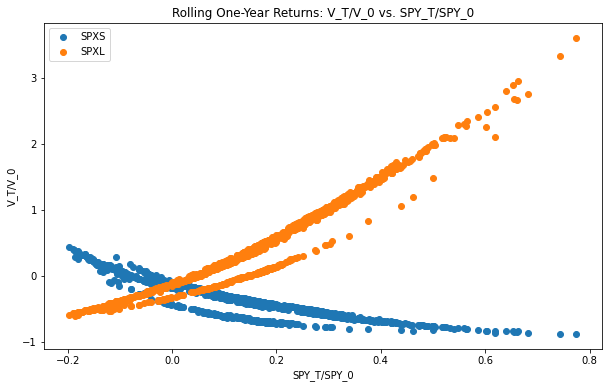

In [29]:
# Rolling one-year returns
rolling_one_year_returns = data.pct_change(periods=252).dropna()

# Plot of V_T/V_0 as a function of SPY_T/SPY_0
plt.figure(figsize=(10, 6))

for etf in ['SPXS', 'SPXL']:
    plt.scatter(rolling_one_year_returns['SPY'], rolling_one_year_returns[etf], label=etf)

plt.title('Rolling One-Year Returns: V_T/V_0 vs. SPY_T/SPY_0')
plt.xlabel('SPY_T/SPY_0')
plt.ylabel('V_T/V_0')
plt.legend()
plt.show()

### 2-1/

The rolling one-year returns of SPXL and SPXS show a non-linear relationship with the returns of the delta one exposure S&P 500 (SPY). This indicates that the performance of these leveraged ETFs may not always track the underlying index as expected, especially over longer periods.

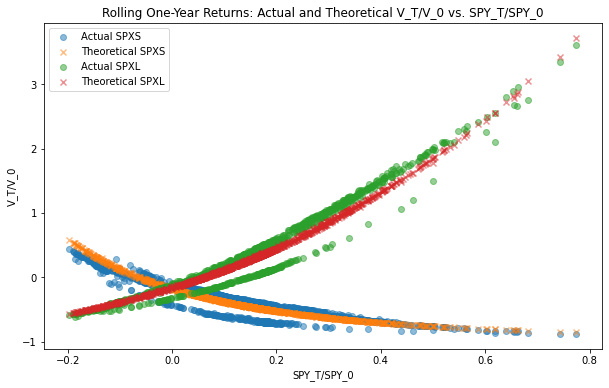

In [30]:
# Daily percentage changes of the S&P 500
percentage_changes_sp500 = data['^GSPC'].pct_change().dropna()

# The daily volatility of the S&P 500
daily_volatility_sp500 = log_returns['^GSPC'].std()

# Theoretical value of the ETFs
leverage = {'SPXS': -3, 'SPXL': 3}
theoretical_etfs = pd.DataFrame(index=data.index, columns=['SPXS', 'SPXL'])

for etf, l in leverage.items():
    V_0 = data[etf].iloc[0]
    S_0 = data['^GSPC'].iloc[0]
    exp_term = np.exp(-0.5 * (l**2 - l) * daily_volatility_sp500**2 * np.arange(len(data)))
    S_T_over_S_0 = (data['^GSPC'] / S_0) ** l
    V_T = V_0 * S_T_over_S_0 * exp_term
    theoretical_etfs[etf] = V_T

# Rolling one-year returns for actual ETFs and theoretical ETFs
rolling_one_year_returns_actual = data.pct_change(periods=252).dropna()
rolling_one_year_returns_theoretical = theoretical_etfs.pct_change(periods=252).dropna()

# Plot of the actual and theoretical V_T/V_0 as a function of SPY_T/SPY_0
plt.figure(figsize=(10, 6))

for etf in ['SPXS', 'SPXL']:
    plt.scatter(rolling_one_year_returns_actual['SPY'], rolling_one_year_returns_actual[etf], label=f'Actual {etf}', alpha=0.5)
    plt.scatter(rolling_one_year_returns_actual['SPY'], rolling_one_year_returns_theoretical[etf], label=f'Theoretical {etf}', marker='x', alpha=0.5)

plt.title('Rolling One-Year Returns: Actual and Theoretical V_T/V_0 vs. SPY_T/SPY_0')
plt.xlabel('SPY_T/SPY_0')
plt.ylabel('V_T/V_0')
plt.legend()
plt.show()

### 2-2/

The actual and theoretical values are close but do not perfectly match. This could be due to the fact that the leverage ratio is not always perfectly maintained by the ETFs as we saw before. In order to evaluate the goodness of fit, we can calculate the R-squared value for each ETF.

In [31]:
# Calculate R-squared values for each ETF
r_squared_values = {}

for etf in ['SPXS', 'SPXL']:
    r_squared = r2_score(rolling_one_year_returns_actual[etf], rolling_one_year_returns_theoretical[etf])
    r_squared_values[etf] = r_squared

# Print R-squared values
for etf, r_squared in r_squared_values.items():
    print(f'R-squared value for {etf}: {r_squared:.4f}')

R-squared value for SPXS: 0.8192
R-squared value for SPXL: 0.9428


The R-squared value represents the proportion of the variance in the dependent variable that is predictable from the independent variable. A higher R-squared value indicates a better fit.
We can see that both R-squared values are good since they are higher than 80%. However, SPXL have a higher match with the theoretical value. Overall, SPXL could be trusted, in the mean time one should be more precautious with SPXS.

### 2-3/

This analysis helps investors understand the return characteristics of the SPXL and SPXS ETFs, their relationship with the S&P 500, and the impact of constant leverage on their performance. It also provides insights into the actual and theoretical ETF values and how well they align with their respective claims of 3x times long and short constant leverage.
Based on the analysis, the following observations can be made:
-The actual and theoretical values of the ETFs are close, but they do not perfectly match. As said before this could be due to the fact that the leverage ratio is not always perfectly maintained by the ETFs, or another reason might be the daily rebalancing of ETFs.
-The rolling one-year returns of SPXL and SPXS show a non-linear relationship with the returns of the delta one hedged S&P 500 (SPY). This indicates that the performance of these leveraged ETFs may not always track the underlying index as expected, especially over longer periods.
Finally, As for recommending these products, it depends on the investor's risk tolerance, investment horizon, and objectives. We believe from our analysis that leveraged ETFs like SPXL and SPXS might be designed for short-term trading and are not suitable for long-term investment strategies (one year or more). They can provide amplified exposure to the S&P 500 index, but they also carry higher risks due to the leverage and daily rebalancing. As we have seen from our statistical analysis in all the years and over the overall period SPY offered either comparable sharpe ratio or even higher. If an investor is looking for a more straightforward and less risky exposure to the S&P 500 index, they might consider investing in a standard index ETF, such as SPY which offer better long term risk adjusted retuns.
In summary, while these leveraged ETFs may offer tactical trading opportunities for sophisticated investors with a short-term focus, they are not suitable for long-term investors or those with a lower risk tolerance.

# 3/ The product provider FAQ

The description provided by Direxion about their Leveraged & Inverse ETFs gives a clear warning that these products are not suitable for conservative investors and are designed for sophisticated and aggressive investors who are willing to accept substantial losses in short periods of time. They mention that these investors should have an understanding of the unique nature and performance characteristics of funds which seek leveraged daily investment results and be able to manage their portfolio actively.

For a layman investor, this description may not fully explain the complex nature of these products. What we would suggest here as modifications to better manage investors expectations are the following points:

- Clearly state that these products are intended for short-term trading and not for long-term buy-and-hold strategies. Explain that the performance of these ETFs over longer periods are worse than SPY for example regarding risk adjusted returns and may not match the expected returns based on the underlying index.

- Include examples of the potential gains and losses that can be experienced by investing in these products (as we did in the current analysis),while emphasizing that returns can be magnified both on the upside and the downside.